In [2]:
import os
import numpy   as np
import nibabel as nib
import nilearn
import nipype
import pylab
import matplotlib.pyplot as plt
import scipy
import torchio
import SimpleITK as sitk

from nilearn import plotting

211021-06:40:43,656 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.6.1


/home/swapna91/virtualenvs/Uvenv2/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


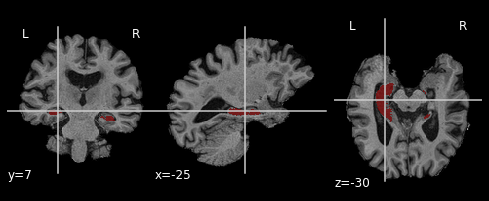

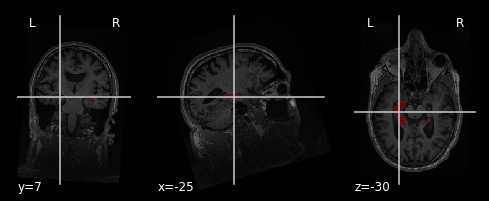

In [4]:
imgr = nib.load('/home/swapna91/scratch/UMAGeT_21v1/data/brains/2016_07_13-ADB0010-11-MPRAGEADNI_iPAT2_1.mnc')
img  = nib.load('/home/swapna91/scratch/UMAGeT_21v1/data_extracted/brains/ADB0010_t1.nii')

msk = nib.load('/home/swapna91/scratch/UMAGeT_21v1/data_extracted/target_labels/ADB0010_labels.nii')

plotting.plot_roi(roi_img=msk, bg_img=img, cmap=plt.cm.get_cmap('jet', 1))
plotting.plot_roi(roi_img=msk, bg_img=imgr, cmap=plt.cm.get_cmap('jet', 1))

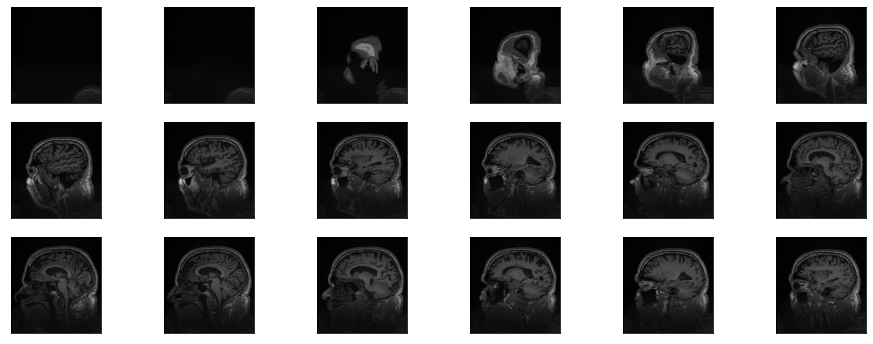

In [25]:
# Raw Image
imgr = nib.load('/home/swapna91/scratch/UMAGeT_21v1/data/brains/2016_07_13-ADB0010-11-MPRAGEADNI_iPAT2_1.mnc')
display(imgr.get_fdata())
#size=imgr.GetSize()
#myshow3d(imgr,yslices=range(50,size[1]-50,20), zslices=range(50,size[2]-50,20), dpi=30)

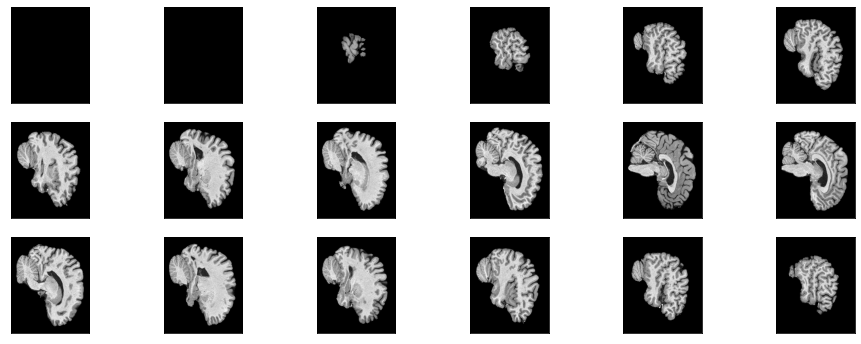

In [29]:
imgr = nib.load('/home/swapna91/scratch/UMAGeT_21v1/data_extracted/data_aug/brains/ADB0015_t1_1r0.nii')
display(imgr.get_fdata())

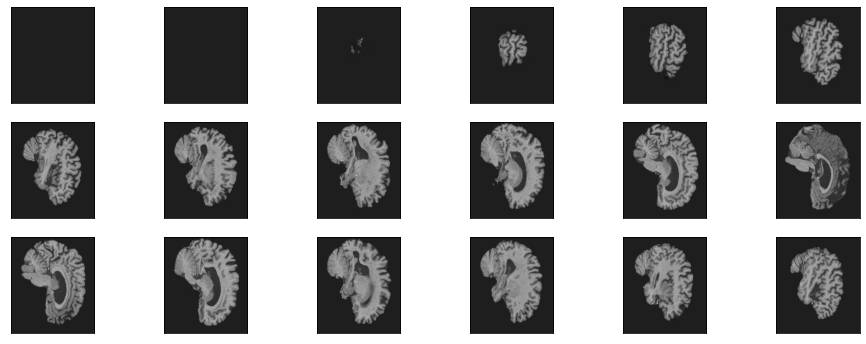

In [30]:
imgr = nib.load('/home/swapna91/scratch/UMAGeT_21v1/data_extracted/data_aug/brains/ADB0010_t1_1r1.nii')
display(imgr.get_fdata())

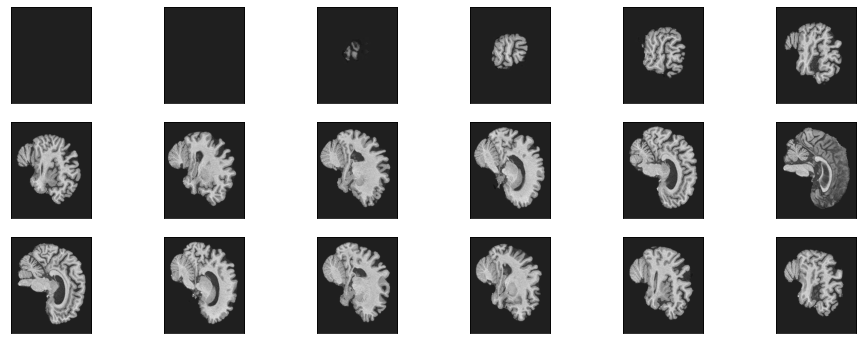

In [31]:
imgr = nib.load('/home/swapna91/scratch/UMAGeT_21v1/data_extracted/data_aug/brains/ADB0027_t1_1r-2.nii')
display(imgr.get_fdata())

In [5]:
def display(im3d, cmap="gray", step=7):
    _, axes = plt.subplots(nrows=3, ncols=6, figsize=(16, 10))

    vmin = im3d.min()
    vmax = im3d.max()

    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])

In [9]:
def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05, dpi=80):
    size = img.GetSize()
    img_xslices = [img[s,:,:] for s in xslices]
    img_yslices = [img[:,s,:] for s in yslices]
    img_zslices = [img[:,:,s] for s in zslices]
    
    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))
    
        
    img_null = sitk.Image([0,0], img.GetPixelIDValue(), img.GetNumberOfComponentsPerPixel())
    
    img_slices = []
    d = 0
    
    if len(img_xslices):
        img_slices += img_xslices + [img_null]*(maxlen-len(img_xslices))
        d += 1
        
    if len(img_yslices):
        img_slices += img_yslices + [img_null]*(maxlen-len(img_yslices))
        d += 1
     
    if len(img_zslices):
        img_slices += img_zslices + [img_null]*(maxlen-len(img_zslices))
        d +=1
    
    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen,d])
        #TODO check in code to get Tile Filter working with VectorImages
        else:
            img_comps = []
            for i in range(0,img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen,d]))
            img = sitk.Compose(img_comps)
    
    myshow(img, title, margin, dpi) 

In [13]:
def myshow(img, title=None, margin=0.05, dpi=80 ):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    
    
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
   
    
    # Make a figure big enough to accomodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

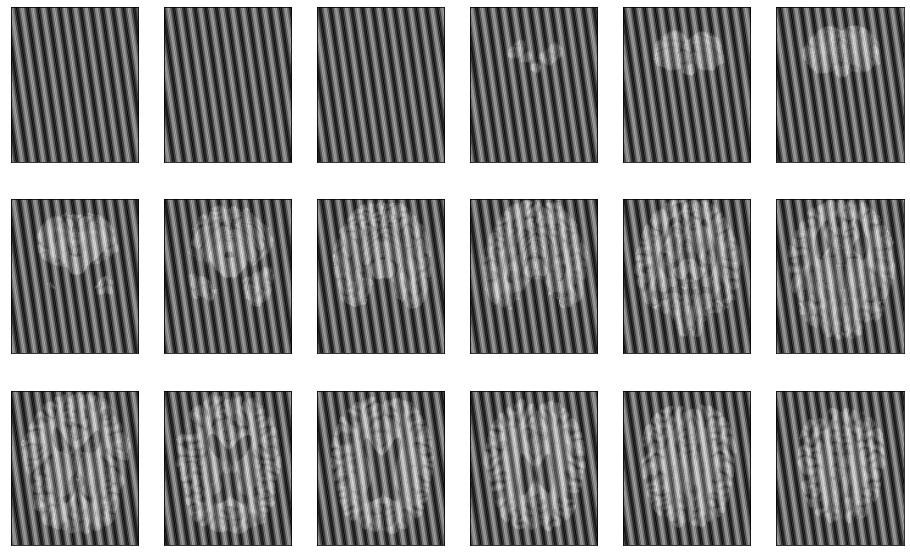

In [60]:

import torch
imgFile = sitk.ReadImage("/home/swapna91/scratch/UMAGeT_21v1/data/brains/ADB0010_t1.nii")
mskFile = sitk.ReadImage("/home/swapna91/scratch/UMAGeT_21v1/data/target_labels/ADB0010_labels.nii")
#img = imgFile.get_fdata()

#to_ras = torchio.ToCanonical()
#img_ras = to_ras(img)


add_spike = torchio.RandomSpike(num_spikes=(2,2))
with_spike = add_spike(imgFile)

#msk_ras = torchio.ToCanonical(msk)

#img_spiked = torchio.RandomSpike(img)
display(sitk.GetArrayFromImage(with_spike))


In [72]:
all_axes    = [(1, 0), (1, 2), (0, 2)]
axes        = np.random.choice(3,1) 
all_axes[axes[0]]

(1, 2)

In [1]:
add_ghosts = torchio.RandomGhosting(num_ghosts=1, intensity=1) 
img_ghosted = add_ghosts(imgFile)
display(sitk.GetArrayFromImage(img_ghosted))

NameError: name 'torchio' is not defined

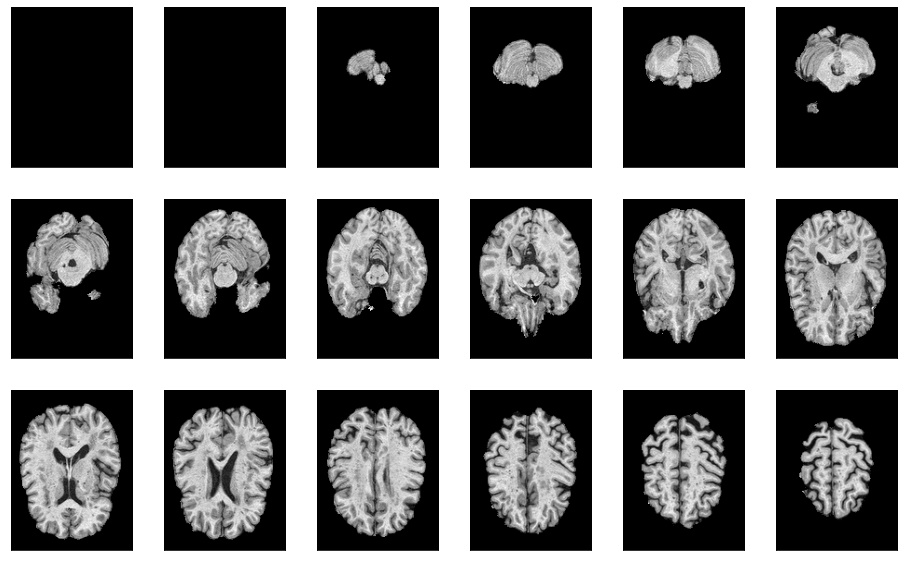

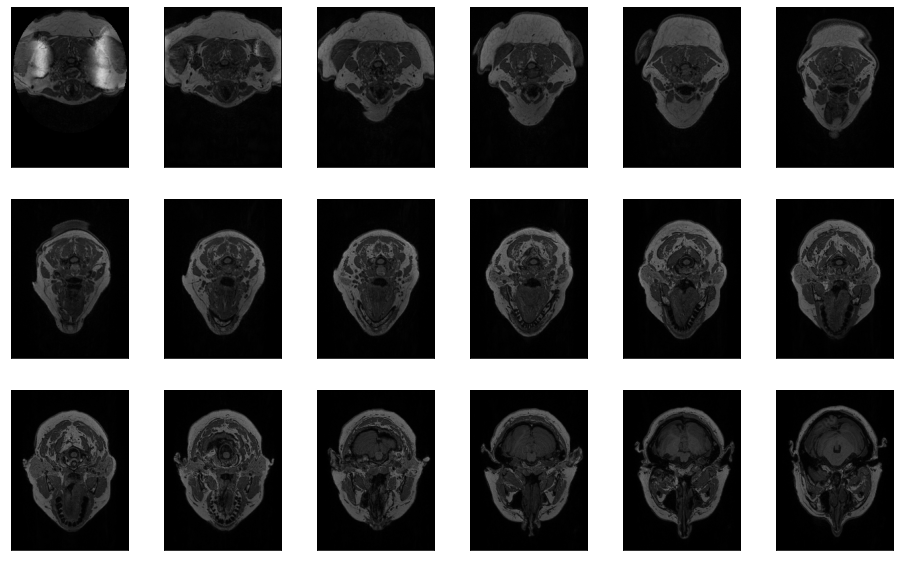

In [7]:
imgFile1 = sitk.ReadImage("/home/swapna91/scratch/UMAGeT_21v1/data_all/brains/ADNI024S6202_t1.nii")
imgFile2 = sitk.ReadImage("/home/swapna91/projects/def-mchakrav-ab/swapna91/rawData/rawData_nii/ADNI024S6202_t1.nii")
#mskFile = sitk.ReadImage("/home/swapna91/scratch/UMAGeT_21v1/data/target_labels/ADNI024S6202_labels.nii")

display(sitk.GetArrayFromImage(imgFile1))
display(sitk.GetArrayFromImage(imgFile2))

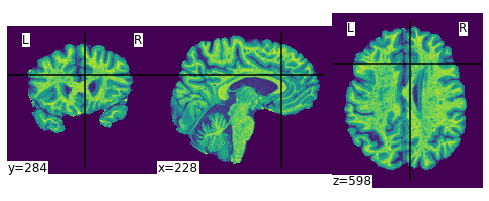

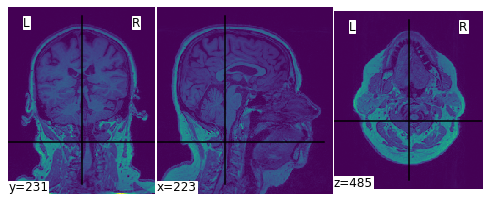

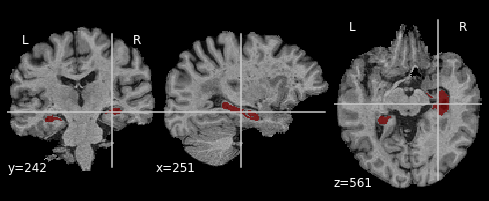

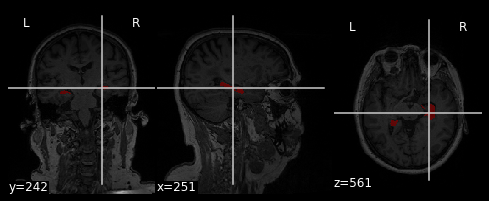

In [13]:
img1 = nib.load("/home/swapna91/scratch/UMAGeT_21v1/data_all/brains/ADNI024S6202_t1.nii")
img2 = nib.load("/home/swapna91/projects/def-mchakrav-ab/swapna91/rawData/rawData_nii/ADNI024S6202_t1.nii")

msk = nib.load("/home/swapna91/scratch/UMAGeT_21v1/data_all/target_labels/ADNI024S6202_labels.nii")

plotting.plot_img(img1)
plotting.plot_img(img2)

plotting.plot_roi(roi_img=msk, bg_img=img1, cmap=plt.cm.get_cmap('jet', 1))
plotting.plot_roi(roi_img=msk, bg_img=img2, cmap=plt.cm.get_cmap('jet', 1))


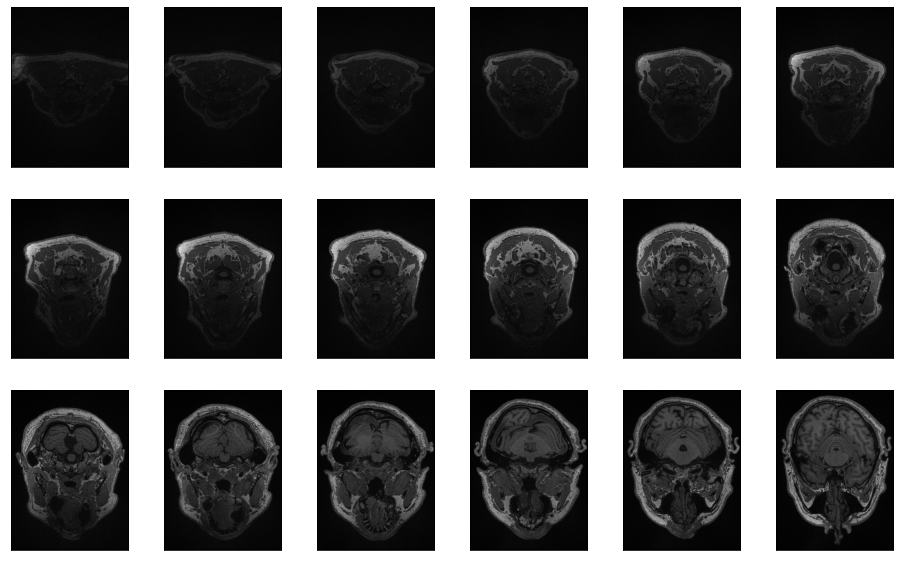

In [33]:
reader = sitk.ImageFileReader()
reader.SetImageIO("MINCImageIO")
reader.SetFileName("/home/swapna91/projects/def-mchakrav-ab/swapna91/rawData/rawData/ABD0005_t1.mnc")
image = reader.Execute()

display(sitk.GetArrayFromImage(image))

In [ ]:
writer = sitk.ImageFileWriter()
writer.SetFileName(outputImageFileName)
writer.Execute(image)

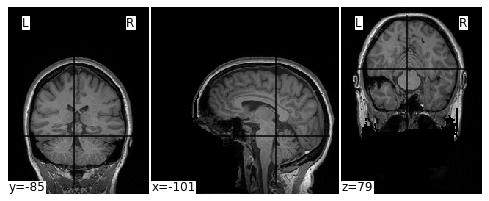

In [40]:
img1 = nib.load("/home/swapna91/projects/def-mchakrav-ab/swapna91/rawData/rawData_nii/CC410251_t1.nii")

plotting.plot_img(img1,cmap="gray")

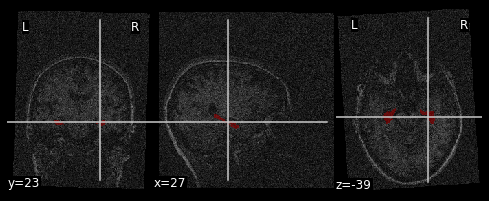

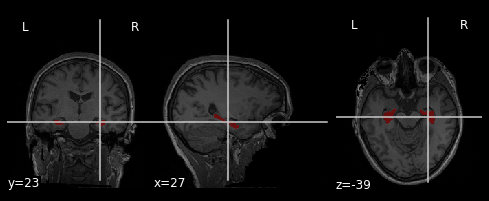

In [84]:
subject_id = "CC420180"
img1 = nib.load(os.path.join("/home/swapna91/scratch/UMAGeT_21v1/data/data_aug/brains"       ,subject_id+"_t1_norm1-rC0-n1-d0-gh0-sp0.nii"))
img2 = nib.load(os.path.join("/home/swapna91/scratch/UMAGeT_21v1/data/data_aug/brains"       ,subject_id+"_t1_norm1-rC0-n0-d0-gh0-sp0.nii"))
msk1 = nib.load(os.path.join("/home/swapna91/scratch/UMAGeT_21v1/data/data_aug/target_labels",subject_id+"_labels_norm1-rC0-n1-d0-gh0-sp0.nii"))

#img1 = nib.load(os.path.join("/home/swapna91/scratch/UMAGeT_21v1/data/data_aug/brains/ADNI020S6566_t1_norm1-rA6-nR0G0-d0.nii"))
#msk1 = nib.load(os.path.join("/home/swapna91/scratch/UMAGeT_21v1/data/data_aug/target_labels/ADNI020S6566_labels_norm1-rA6-nR0G0-d0.nii"))

plotting.plot_roi(roi_img=msk1,bg_img=img1,cmap="jet_r")
plotting.plot_roi(roi_img=msk1,bg_img=img2,cmap="jet_r")

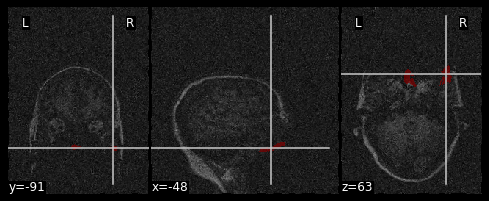

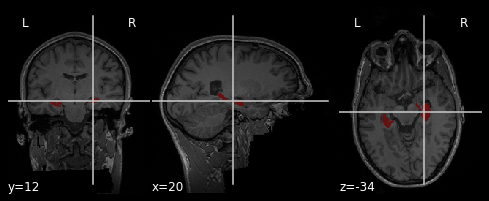

In [89]:
subject_id1 = "CC221336"
subject_id  = "CC610050"
img1 = nib.load(os.path.join("/home/swapna91/scratch/UMAGeT_21v1/data/data_aug/brains"       ,subject_id+"_t1_norm1-rC0-n1-d1-gh0-sp0.nii"))
img2 = nib.load(os.path.join("/home/swapna91/scratch/UMAGeT_21v1/data/data_aug/brains"       ,subject_id1+"_t1_norm1-rC0-n0-d0-gh0-sp0.nii"))

msk1 = nib.load(os.path.join("/home/swapna91/scratch/UMAGeT_21v1/data/data_aug/target_labels",subject_id+"_labels_norm1-rC0-n1-d1-gh0-sp0.nii"))
msk2 = nib.load(os.path.join("/home/swapna91/scratch/UMAGeT_21v1/data/data_aug/target_labels",subject_id1+"_labels_norm1-rC0-n0-d0-gh0-sp0.nii"))

#img1 = nib.load(os.path.join("/home/swapna91/scratch/UMAGeT_21v1/data/data_aug/brains/ADNI020S6566_t1_norm1-rA6-nR0G0-d0.nii"))
#msk1 = nib.load(os.path.join("/home/swapna91/scratch/UMAGeT_21v1/data/data_aug/target_labels/ADNI020S6566_labels_norm1-rA6-nR0G0-d0.nii"))

plotting.plot_roi(roi_img=msk1,bg_img=img1,cmap="jet_r")
plotting.plot_roi(roi_img=msk2,bg_img=img2,cmap="jet_r")

In [76]:
img2 = nib.load(os.path.join("/home/swapna91/scratch/UMAGeT_21v1/data/data_aug/brains/ADNI020S6566_t1_norm1-rC0-nR0G1-d0-gh0-sp0.nii"))

img_wnoise_arr   = img2.get_fdata()
noise_percentage = np.around(np.random.choice((0.02,0.04,0.06,0.08,0.10),1),2)[0]
standard_dev     = np.max(img_wnoise_arr)*noise_percentage

shape_x = np.int(img_wnoise_arr.shape[0])
shape_y = np.int(img_wnoise_arr.shape[1])
shape_z = np.int(img_wnoise_arr.shape[2])

gaussian_real = np.random.normal(loc=0, scale=standard_dev, size=(shape_x, shape_y, shape_z))
gaussian_imag = np.random.normal(loc=0, scale=standard_dev, size=(shape_x, shape_y, shape_z))*1j

gaussian_complex = gaussian_real + gaussian_imag

print(gaussian_complex)

[[[-0.85394273+0.08914575j  0.0943404 +0.65999516j
    0.1732248 +0.52624574j]
  [ 0.0777683 +0.02610995j  0.01939022+0.78679314j
    0.80273532-1.10073705j]
  [-0.28877793+0.62858839j  0.86227603+0.14656149j
   -0.03001488+0.78587622j]]

 [[-0.8884522 +0.71526107j  0.68111687-0.46473332j
    1.31512632-0.86419739j]
  [-0.33430467-0.68010258j  0.18383944+0.68624238j
   -0.71889207+0.30764632j]
  [-0.68868986-0.35336234j -0.15202528+0.49863971j
    0.15224935-0.54867726j]]

 [[-0.19149773+0.9019504j  -0.7276684 -0.99085418j
   -0.48292323+0.32966j   ]
  [ 1.22768713-0.89251169j  0.14792939+0.14283478j
   -0.44185231-1.15458153j]
  [-0.54171321+0.33445874j  0.48559553+0.24011979j
   -0.43264072+0.33655743j]]]


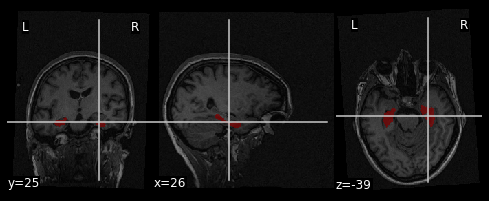

In [96]:
subject_id  = "CC420162"
img1 = nib.load(os.path.join("/home/swapna91/scratch/UMAGeT_21v1/data/data_aug/brains"       ,"CC420180_t1_norm1-rC0-n1-d1-gh0-sp0.nii"))
msk1 = nib.load(os.path.join("/home/swapna91/scratch/UMAGeT_21v1/data/data_aug/target_labels","CC420180_labels_norm1-rC0-n1-d1-gh0-sp0.nii"))

plotting.plot_roi(roi_img=msk1,bg_img=img1,cmap="jet_r")
